# Image Captioning Project

In this project you will define and train an image-to-caption model, that can produce descriptions for real world images!

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/encoder_decoder.png?raw=1" style="width:70%">

Model architecture: CNN encoder and RNN decoder. 
(https://research.googleblog.com/2014/11/a-picture-is-worth-thousand-coherent.html)

# Importing libraries

In [30]:
import sys
sys.path.append("..")

import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import utils
import tqdm_utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import os
from keras_utils import reset_tf_session

# Download data

Takes 10 hours and 20 GB. We've downloaded necessary files for you.

Relevant links (just in case):
- train images http://msvocds.blob.core.windows.net/coco2014/train2014.zip
- validation images http://msvocds.blob.core.windows.net/coco2014/val2014.zip
- captions for both train and validation http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip

# Extract image features

We will use pre-trained InceptionV3 model for CNN encoder (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html) and extract its last hidden layer as an embedding:

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/inceptionv3.png?raw=1" style="width:70%">

In [2]:
IMG_SIZE = 299

In [3]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

In [4]:
reset_tf_session()
encoder, preprocess_for_model = get_cnn_encoder()

# extract train features
train_img_embeds, train_img_fns = utils.apply_model(
    "train2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(train_img_embeds, "train_img_embeds.pickle")
utils.save_pickle(train_img_fns, "train_img_fns.pickle")

# extract validation features
val_img_embeds, val_img_fns = utils.apply_model(
    "val2014.zip", encoder, preprocess_for_model, input_shape=(IMG_SIZE, IMG_SIZE))
utils.save_pickle(val_img_embeds, "val_img_embeds.pickle")
utils.save_pickle(val_img_fns, "val_img_fns.pickle")

# sample images for learners
def sample_zip(fn_in, fn_out, rate=0.01, seed=42):
    np.random.seed(seed)
    with zipfile.ZipFile(fn_in) as fin, zipfile.ZipFile(fn_out, "w") as fout:
        sampled = filter(lambda _: np.random.rand() < rate, fin.filelist)
        for zInfo in sampled:
            fout.writestr(zInfo, fin.read(zInfo))

sample_zip("train2014.zip", "train2014_sample.zip")
sample_zip("val2014.zip", "val2014_sample.zip")

HBox(children=(IntProgress(value=0, max=82784), HTML(value='')))

HBox(children=(IntProgress(value=0, max=40505), HTML(value='')))

In [5]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [6]:
train_img_embeds[0]

array([ 0.13804647,  0.05108421,  0.22299166, ...,  0.03206247,
        0.00304695,  0.52839726], dtype=float32)

# Extract captions for images

In [7]:
# extract captions from zip
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


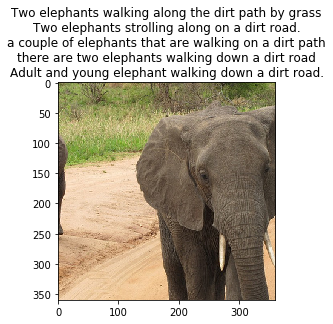

In [8]:
# look at training example (each has 5 captions)
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=145)

# Prepare captions for training

In [9]:
# preview captions data
train_captions[:5]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another'],
 ['A tabby cat sitting in front of a car.',
  'A brown and black cat sitting on driveway next to a white car.',
  'A sleepy looking cat sitting in front of a white car.',
  'A cat sits in front of a parked car.',
  'A cat sitting in front of a parked white car.  '],
 ['A woman walks down an empty street next to a large street clock.',
  'A clock is on top of the pole on the sidewalk',
  'A city street with a clock on the sidewalk.',
  'A clock is mounted to a pole

In [10]:
# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

# split sentence into tokens (split into lowercased words)
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    """
    Return {token: index} for all train tokens (words) that occur 5 times or more, 
        `index` should be from 0 to N, where N is a number of unique tokens in the resulting dictionary.
    Use `split_sentence` function to split sentence into tokens.
    Also, add PAD (for batch padding), UNK (unknown, out of vocabulary), 
        START (start of sentence) and END (end of sentence) tokens into the vocabulary.
    """
    index = 0
    vocab = {}
    vocab_temp = {}
    for captions in train_captions:
      for sentence in captions:
        tokens = split_sentence(sentence)
        for i in tokens:
          if i in vocab_temp:
            vocab_temp[i] = vocab_temp[i]+1
          else:
            vocab_temp[i] = 1
    for token, count in vocab_temp.items():
      if count >=5:
        vocab[token] = index
        index = index + 1
    #vocab = ### YOUR CODE HERE ###
    vocab[PAD] = index+1
    vocab[UNK] = index+2
    vocab[START] = index+3
    vocab[END] = index+4
    return {token: index for index, token in enumerate(sorted(vocab))}
    
def caption_tokens_to_indices(captions, vocab):
    """
    `captions` argument is an array of arrays:
    [
        [
            "image1 caption1",
            "image1 caption2",
            ...
        ],
        [
            "image2 caption1",
            "image2 caption2",
            ...
        ],
        ...
    ]
    Use `split_sentence` function to split sentence into tokens.
    Replace all tokens with vocabulary indices, use UNK for unknown words (out of vocabulary).
    Add START and END tokens to start and end of each sentence respectively.
    For the example above you should produce the following:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    """
    res = []
    for caption in captions:
      listu = []
      for j in caption:
        listt = []
        listt.append(vocab[START])
        for i in split_sentence(j):
          if i in vocab:
            listt.append(vocab[i])
          else:
            listt.append(vocab[UNK])
        listt.append(vocab[END])
        listu.append(listt)
      res.append(listu)
    return res

In [11]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [12]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

In [13]:
len(train_captions_indexed)

82783

Captions have different length, but we need to batch them, that's why we will add PAD tokens so that all sentences have an equal length. 

We will crunch LSTM through all the tokens, but we will ignore padding tokens during loss calculation.

In [14]:
# we will use this during training
import pandas as pd
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    df = pd.DataFrame(batch_captions, dtype=int)
    if max_len == None:
      return df.fillna(pad_idx).values
    elif max_len > len(df.columns):
      return df.fillna(pad_idx).values
    else:
      df = df.iloc[:, :max_len]
      return df.fillna(pad_idx).values

In [15]:
# make sure we use correct argument in caption_tokens_to_indices
assert len(caption_tokens_to_indices(train_captions[:10], vocab)) == 10
assert len(caption_tokens_to_indices(train_captions[:5], vocab)) == 5

# Training

## Define architecture

Since our problem is to generate image captions, RNN text generator should be conditioned on image. The idea is to use image features as an initial state for RNN instead of zeros. 

Remember that you should transform image feature vector to RNN hidden state size by fully-connected layer and then pass it to RNN.

During training we will feed ground truth tokens into the lstm to get predictions of next tokens. 

Notice that we don't need to feed last token (END) as input (http://cs.stanford.edu/people/karpathy/):

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/encoder_decoder_explained.png?raw=1" style="width:50%">

In [16]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]
IMG_EMBED_SIZE

2048

In [17]:
# remember to reset your graph if you want to start building it from scratch!
s = reset_tf_session()
tf.set_random_seed(42)
tf.reset_default_graph()

Here we define decoder graph.

We use Keras layers where possible because we can use them in functional style with weights reuse like this:
```python
dense_layer = L.Dense(42, input_shape=(None, 100) activation='relu')
a = tf.placeholder('float32', [None, 100])
b = tf.placeholder('float32', [None, 100])
dense_layer(a)  # that's how we applied dense layer!
dense_layer(b)  # and again
```

Here's a figure to help you with flattening in decoder:
<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week6/images/flatten_help.jpg?raw=1" style="width:80%">

In [23]:
class decoder:
    # [batch_size, IMG_EMBED_SIZE] of CNN image features
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    # [batch_size, time steps] of word ids
    sentences = tf.placeholder('int32', [None, None])
    
    # we use bottleneck here to reduce the number of parameters
    # image embedding -> bottleneck
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    # image embedding bottleneck -> lstm initial state
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    # word -> embedding
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    # lstm cell (from tensorflow)
    lstm = tf.contrib.rnn.LSTMCell(LSTM_UNITS)
    
    # we use bottleneck here to reduce model complexity
    # lstm output -> logits bottleneck
    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    # logits bottleneck -> logits for next token prediction
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    
    # initial lstm cell state of shape (None, LSTM_UNITS),
    # we need to condition it on `img_embeds` placeholder.
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))### YOUR CODE HERE ###

    # embed all tokens but the last for lstm input,
    # remember that L.Embedding is callable,
    # use `sentences` placeholder as input.
    word_embeds = word_embed(sentences[:,:-1])### YOUR CODE HERE ###
    
    # during training we use ground truth tokens `word_embeds` as context for next token prediction.
    # that means that we know all the inputs for our lstm and can get 
    # all the hidden states with one tensorflow operation (tf.nn.dynamic_rnn).
    # `hidden_states` has a shape of [batch_size, time steps, LSTM_UNITS].
    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds, initial_state=tf.contrib.rnn.LSTMStateTuple(c0, h0))

    # now we need to calculate token logits for all the hidden states
    
    # first, we reshape `hidden_states` to [-1, LSTM_UNITS]
    flat_hidden_states = tf.reshape(hidden_states, [-1, LSTM_UNITS])### YOUR CODE HERE ###

    # then, we calculate logits for next tokens using `token_logits_bottleneck` and `token_logits` layers
    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))### YOUR CODE HERE ###
    
    # then, we flatten the ground truth token ids.
    # remember, that we predict next tokens for each time step,
    # use `sentences` placeholder.
    flat_ground_truth = tf.reshape(sentences[:,1:], [-1,])### YOUR CODE HERE ###

    # we need to know where we have real tokens (not padding) in `flat_ground_truth`,
    # we don't want to propagate the loss for padded output tokens,
    # fill `flat_loss_mask` with 1.0 for real tokens (not pad_idx) and 0.0 otherwise.
    flat_loss_mask = tf.not_equal(flat_ground_truth, pad_idx)### YOUR CODE HERE ###

    # compute cross-entropy between `flat_ground_truth` and `flat_token_logits` predicted by lstm
    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )

    # compute average `xent` over tokens with nonzero `flat_loss_mask`.
    # we don't want to account misclassification of PAD tokens, because that doesn't make sense,
    # we have PAD tokens for batching purposes only!
    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))### YOUR CODE HERE ###

In [24]:
# define optimizer operation to minimize the loss
sess = tf.InteractiveSession()
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

# will be used to save/load network weights.
# you need to reset your default graph and define it in the same way to be able to load the saved weights!
saver = tf.train.Saver()

# intialize all variables
sess.run(tf.global_variables_initializer())

/Users/sparshgarg/anaconda3/python/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Training loop
Evaluate train and validation metrics through training and log them. Ensure that loss decreases.

In [26]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [27]:
# generate batch via random sampling of images and captions for them,
# we use `max_len` parameter to control the length of the captions (truncating long captions)
from operator import itemgetter 
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    image_batch = np.random.choice(range(len(images_embeddings)), batch_size, replace=False)
    batch_image_embeddings = images_embeddings[image_batch]### YOUR CODE HERE ###
    captions = itemgetter(*image_batch)(indexed_captions)
    batch_captions = []
    for caption in captions:
      batch_captions.append(caption[np.random.randint(5)])
    #batch_captions = [caption[np.random.randint(5)] for caption in indexed_captions[image_batch]]
    batch_captions_matrix = batch_captions_to_matrix(batch_captions, pad_idx, max_len= max_len)### YOUR CODE HERE ###
    
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [28]:
batch_size = 64
n_epochs = 12
n_batches_per_epoch = 1000
n_validation_batches = 100  # how many batches are used for validation after each epoch

Look at the training and validation loss, they should be decreasing!

In [31]:
# actual training loop
MAX_LEN = 20  # truncate long captions to speed up training

# to make training reproducible
np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm_utils.tqdm_notebook_failsafe(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += sess.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += sess.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(sess, os.path.abspath("weights_{}".format(epoch)))
    
print("Finished!")

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 0, train loss: 4.230704149723053, val loss: 3.5887263870239257


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 1, train loss: 3.295511825799942, val loss: 3.104984788894653


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 2, train loss: 3.0001438076496125, val loss: 2.950798649787903


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 3, train loss: 2.8487238969802857, val loss: 2.8506575632095337


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 4, train loss: 2.7631089384555816, val loss: 2.79245245218277


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 5, train loss: 2.7011049077510836, val loss: 2.7422674536705016


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 6, train loss: 2.6443248898983, val loss: 2.699961898326874


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 7, train loss: 2.6012228300571443, val loss: 2.6737804985046387


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 8, train loss: 2.5696900119781496, val loss: 2.614234440326691


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 9, train loss: 2.5345803701877596, val loss: 2.623519389629364


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 10, train loss: 2.5076828496456147, val loss: 2.6036073970794678


HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


Epoch: 11, train loss: 2.4884711983203887, val loss: 2.5930529475212096
Finished!


In [32]:
# check that it's learnt something, outputs accuracy of next word prediction (should be around 0.5)
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 2.383
Accuracy: 0.492537313433
Example 0
Predicted: a room with a furniture and dining furniture white furniture #END# #END# #END# #END# #END# and and and
Truth: hotel suite with kitchen area and yellow and red decor #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a man in on a snow in the snow #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: young girl standing on a snowboard in a clearing #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted: a train that on a tracks next a building of trees #END# #END# #END# #END# #END# #END# #END#
Truth: a train rolls along the tracks past a line of trees #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#



In [33]:
# save graph weights to file!
saver.save(sess, os.path.abspath("weights"))

'/Users/sparshgarg/Dropbox/SantaClara/Object Identification/weights'

# Applying model

Here we construct a graph for our final model.

It will work as follows:
- take an image as an input and embed it
- condition lstm on that embedding
- predict the next token given a START input token
- use predicted token as an input at next time step
- iterate until you predict an END token

In [35]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(sess, os.path.abspath("weights"))  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.contrib.rnn.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from /Users/sparshgarg/Dropbox/SantaClara/Object Identification/weights


ValueError: Attempt to reuse RNNCell <tensorflow.contrib.rnn.python.ops.core_rnn_cell_impl.LSTMCell object at 0x1a320d0e10> with a different variable scope than its first use.  First use of cell was with scope 'rnn/lstm_cell', this attempt is with scope 'lstm_cell'.  Please create a new instance of the cell if you would like it to use a different set of weights.  If before you were using: MultiRNNCell([LSTMCell(...)] * num_layers), change to: MultiRNNCell([LSTMCell(...) for _ in range(num_layers)]).  If before you were using the same cell instance as both the forward and reverse cell of a bidirectional RNN, simply create two instances (one for forward, one for reverse).  In May 2017, we will start transitioning this cell's behavior to use existing stored weights, if any, when it is called with scope=None (which can lead to silent model degradation, so this error will remain until then.)